# 📊 Evaluation in Flotorch

[Flotorch](https://www.flotorch.ai/) provides a comprehensive evaluation framework for Retrieval-Augmented Generation (RAG) systems. It helps assess and compare Large Language Models (LLMs) based on relevance, quality, cost, and performance to support enterprise-grade deployments.

---

## 🧪 Key Evaluation Features

- **Automated LLM Evaluation**  
  Flotorch automates evaluation across:
  - Relevance
  - Fluency
  - Robustness
  - Cost
  - Execution Speed

- **Performance Metrics**  
  It generates quantitative scores for evaluating how well a model performs across different criteria.

- **Cost and Time Insights**  
  Offers pricing and latency breakdowns for different LLM setups, enabling cost-effective choices.

- **Data-Driven Decision-Making**  
  Helps teams align LLM usage with specific application goals, budget, and performance needs.


---

## 🛠️ Evaluation Workflow

1. **Experiment Configuration**  
   Define models, parameters, and goals for evaluation.

2. **Automated Execution**  
   Run evaluation pipelines to generate performance data.

3. **Results Analysis**  
   View dashboards or reports that summarize evaluation results.

4. **Expert Evaluation (Optional)**  
   Combine automatic evaluation with human review for more nuanced feedback.

---

This evaluation framework enables continuous monitoring, benchmarking, and optimization of RAG systems using LLMs, helping organizations deploy more reliable and efficient AI solutions.



In [1]:
import json
# Loading eval prompt file
prompt_file_path = './dataset/eval_prompt.json'
with open(prompt_file_path, 'r') as f:
    prompt = json.load(f)

## Load experiment config

In [2]:
exp_config_data = {
            "temp_retrieval_llm": "0.1",
            "retrieval_service": "bedrock",
            "retrieval_model": "us.amazon.nova-pro-v1:0",
            "eval_retrieval_model": "bedrock/cohere.command-r-v1:0",
            "eval_prompt": prompt,
            "aws_region": "us-west-2"
        }

## Load inference metrics

In [6]:
import json
with open(f"./results/{exp_config_data['retrieval_service']}_inference_metrics.json", "r") as f:
    inference_metrics = json.load(f)

In [5]:
data.keys()

dict_keys(['fixed', 'hierarchical', 'semantic'])

## Load Evaluator Class

### 🧠 Evaluation with `CustomEvaluator`

```python
processor = CustomEvaluator(evaluator_llm=exp_config_data['eval_retrieval_model'])
results = processor.evaluate(data)
```

---

#### 🔹 Step-by-Step Breakdown

| Line | Description |
|------|-------------|
| `processor = CustomEvaluator(...)` | Instantiates a `CustomEvaluator` using a language model specified in the config (`exp_config_data['eval_retrieval_model']`). |
| `results = processor.evaluate(data)` | Runs the evaluation on the `data` using the evaluator, returning performance metrics or scoring output. |

---

#### 🧩 Key Components

- **`CustomEvaluator`**: A custom class designed to handle evaluation logic, potentially wrapping RAGAS or similar frameworks.
- **`evaluator_llm`**: The evaluation language model (e.g. GPT, Claude, etc.) used for scoring responses.
- **`data`**: A list of evaluation items (e.g. questions, answers, reference contexts).
- **`results`**: The output from the evaluation — typically a dictionary or structured result with metric scores.


In [4]:
from utils.evaluator import CustomEvaluator

In [11]:
processor = CustomEvaluator(evaluator_llm_info = exp_config_data)
evaluation_metrics = {}
for each_chunking_strategy, inference_data in inference_metrics.items():
    results = processor.evaluate(inference_data)
    evaluation_metrics[each_chunking_strategy] = results
    print(f"Evaluation completed with {each_chunking_strategy}")

Processing: 100%|██████████| 35/35 [00:28<00:00,  1.23it/s]


Evaluation completed with fixed


Processing: 100%|██████████| 35/35 [00:23<00:00,  1.52it/s]


Evaluation completed with hierarchical


Processing: 100%|██████████| 35/35 [00:26<00:00,  1.33it/s]

Evaluation completed with semantic


### 📦 Calculate Cost

In [12]:
from utils.cost_calculation import calculate_total_cost
evaluation_metrics_with_cost = {}
for each_chunking_strategy, evaluation_data in evaluation_metrics.items():
    total_cost, results = calculate_total_cost(exp_config_data, evaluation_data)
    evaluation_metrics_with_cost[each_chunking_strategy] = results

## Save results to csv file

In [23]:
import csv

csv_file = './results/evaluation_output.csv'

with open(csv_file, mode='w', newline='', encoding='utf-8') as f:
    fieldnames=['question', 'answer', 'inputTokens', 'outputTokens', 'totalTokens', 'latencyMs', 'ground answer', 'chunking_strategy' ,'message','score']
        
    if exp_config_data['retrieval_service'] == 'sagemaker':
        fieldnames.insert(fieldnames.index('message'), 'sagemaker_cost')  # Insert before 'ground answer'
    
    if exp_config_data['retrieval_service'] == 'bedrock':
        fieldnames.insert(fieldnames.index('message'), 'bedrock_input_cost')  # Insert before 'ground answer'
        fieldnames.insert(fieldnames.index('message'), 'bedrock_output_cost')  # Insert before 'ground answer'
        
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    for chunking_strategy, results in evaluation_metrics_with_cost.items():
        for _id, item in enumerate(results):
            answer_metadata = item.get('answer_metadata', {})
            response = item.get('response', {})
    
            row = {
                'question': item.get('question', ''),
                'answer': item.get('answer', ''),
                'inputTokens': answer_metadata.get('inputTokens', ''),
                'outputTokens': answer_metadata.get('outputTokens', ''),
                'totalTokens': answer_metadata.get('totalTokens', ''),
                'latencyMs': answer_metadata.get('latencyMs', ''),
                'ground answer': item.get('gt_answer', ''),
                'chunking_strategy': chunking_strategy,
                'message': response.get('message', ''),
                'score': response.get('score', ''),
            }
    
            if include_sagemaker_cost:
                sagemaker_cost = item.get('sagemaker_cost', {})
                row['sagemaker_cost'] = sagemaker_cost.get('sagemaker_inference_cost', '')
            if include_inference_cost:
                inference_cost = item.get('inference_cost', {})
                row['bedrock_input_cost'] = inference_cost.get('inference_input_cost', '')
                row['bedrock_output_cost'] = inference_cost.get('inference_output_cost', '')
            # print(row['chunking_strategy'])
            writer.writerow(row)


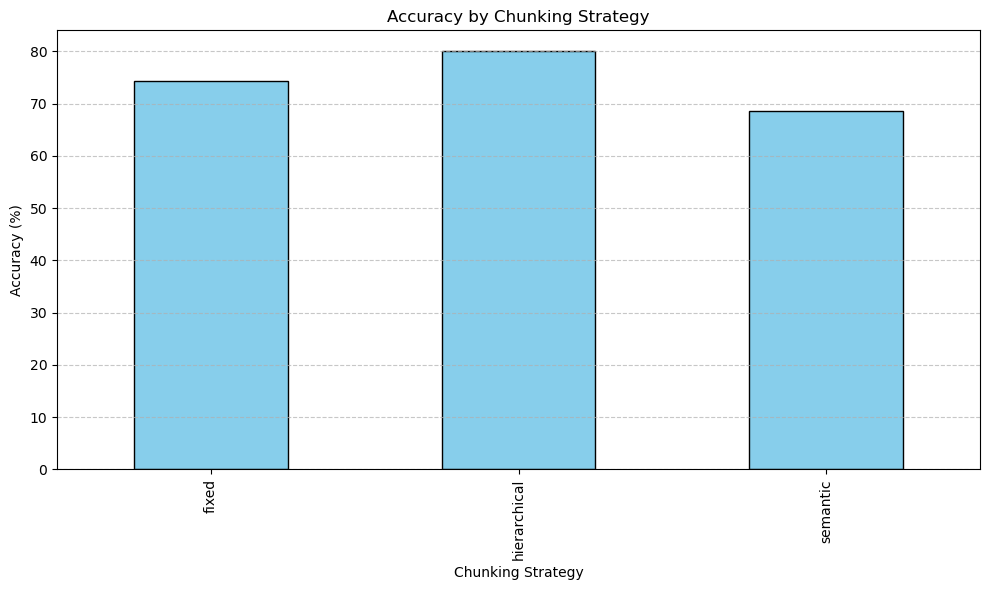

  chunking_strategy  total_samples  avg_score  correct_answers  \
0             fixed             35   0.714286               26   
1      hierarchical             35   0.771429               28   
2          semantic             35   0.685714               24   

   accuracy_percent  
0         74.285714  
1         80.000000  
2         68.571429  


In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "./results/evaluation_output.csv"  # Replace with your actual path
df = pd.read_csv(file_path)

# Group by chunking strategy and compute stats
strategy_stats = df.groupby("chunking_strategy").agg(
    total_samples=("score", "count"),
    avg_score=("score", "mean"),
    correct_answers=("score", lambda x: (x == 1).sum())
)
strategy_stats["accuracy_percent"] = 100 * strategy_stats["correct_answers"] / strategy_stats["total_samples"]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
strategy_stats["accuracy_percent"].plot(kind="bar", ax=ax, color="skyblue", edgecolor="black")
ax.set_title("Accuracy by Chunking Strategy")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Chunking Strategy")
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Display the computed stats
print(strategy_stats.reset_index())
